In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, os.path
import statistics
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
state_coords = pd.read_excel("states_coordinates.xlsx")
state_coords.head()

,state,row,col
0,WA,1,0
1,OR,2,0
2,CA,3,0
3,ID,1,1
4,NV,2,1


In [5]:
total_data = pd.read_csv("Compiled_employment_change_sum.csv")
total_data = total_data.set_index("state")
total_data

,scenario,analysis,emissions,MismatchMult
state,,,,
AL,Electrification,v6.2jedi_high,NNP,0.788139
AL,Electrification,v6.2jedi_low,NNP,0.810023
AL,Electrification,v6.2jedi_mid,NNP,0.791441
AL,Electrification,v6.2nei_high,NNP,0.758180
AL,Electrification,v6.2nei_low,NNP,0.776232
...,...,...,...,...
WY,Reduced RE Resource 95 by 2050,v6.2jedi_low,95% by 2050,-0.138098
WY,Reduced RE Resource 95 by 2050,v6.2jedi_mid,95% by 2050,-0.151636
WY,Reduced RE Resource 95 by 2050,v6.2nei_high,95% by 2050,-0.155912


### compile extreme values

In [18]:
ems_list = ["NNP","95% by 2050","95% by 2035"]
add_name = [""," 95 by 2050"," 95 by 2035"]
for this_ems in ems_list:
    count = 0
    mid_name = "Mid Case"+add_name[ems_list.index(this_ems)]
    for this_state in state_coords["state"].to_list():
        select_data = total_data.query("emissions==@this_ems").loc[this_state]
        select_data = select_data.reset_index()
        max_ind = select_data['MismatchMult'].idxmax()
        min_ind = select_data['MismatchMult'].idxmin()
        more_select_data = select_data.iloc[[max_ind,min_ind],:]
        more_select_data["Type"] = ["max","min"]
        more_select_data["std"] = select_data["MismatchMult"].std()
        more_select_data["mean"] = select_data["MismatchMult"].mean()
        mid_val = select_data.query("scenario==@mid_name").query("analysis=='v6.2jedi_mid'")["MismatchMult"].iloc[0]
        if mid_val > 0:
            not_unanimous = int(any(select_data["MismatchMult"] < 0))
            majority = sum([int(s>0) for s in select_data["MismatchMult"]]) / len(select_data["MismatchMult"])
        else:
            not_unanimous = int(any(select_data["MismatchMult"] > 0))
            majority = sum([int(s<0) for s in select_data["MismatchMult"]]) / len(select_data["MismatchMult"])
        more_select_data["confidence"] = not_unanimous
        more_select_data["majority"] = majority
        if count == 0:
            extreme_data = more_select_data
        else:
            extreme_data = extreme_data.append(more_select_data)
        count = count + 1
    extreme_data_min = extreme_data.query("Type=='min'").set_index("state")
    extreme_data_max = extreme_data.query("Type=='max'").set_index("state")

    states_extreme = state_coords.copy().set_index("state")
    states_extreme["max_scenario"] = extreme_data_max["scenario"]
    states_extreme["max_analysis"] = extreme_data_max["analysis"]
    states_extreme["max_value"] = extreme_data_max["MismatchMult"]
    states_extreme["min_scenario"] = extreme_data_min["scenario"]
    states_extreme["min_analysis"] = extreme_data_min["analysis"]
    states_extreme["min_value"] = extreme_data_min["MismatchMult"]
    states_extreme["std"] = extreme_data_min["std"]
    states_extreme["mean"] = extreme_data_min["mean"]
    states_extreme["diff"] = extreme_data_min["confidence"] # 1 - not unanimous, 0 - unanimous 
    states_extreme["majority"] = extreme_data_min["majority"] # ratio of those matching the mid case
    states_extreme = states_extreme.drop(columns=["row","col"])

    states_extreme["mid_value"] = total_data.query("scenario==@mid_name").query("analysis=='v6.2jedi_mid'")["MismatchMult"]
    #states_extreme["std_1up"] = states_extreme["max_value"] < (states_extreme["std"] + states_extreme["mid_value"])
    #states_extreme["std_2up"] = states_extreme["max_value"] < (2*states_extreme["std"] + states_extreme["mid_value"])
    #states_extreme["std_1down"] = states_extreme["min_value"] > (-states_extreme["std"] + states_extreme["mid_value"])
    #states_extreme["std_2down"] = states_extreme["min_value"] > (-2*states_extreme["std"] + states_extreme["mid_value"])
    #states_extreme["std_count"] = states_extreme["std_1up"].astype(int) + states_extreme["std_2up"] + states_extreme["std_1down"] + states_extreme["std_2down"]
    
    states_extreme.to_csv("net_state_employment"+add_name[ems_list.index(this_ems)].replace(" ","_")+".csv")
    # this is net in terms of 2050 compared to 2022

### calculate the net values only 

In [96]:
all_scenarios = total_data.query("emissions=='NNP'")["scenario"].unique()
add_name_scen = [" 95 by 2050"," 95 by 2035"]

for this_add_name in add_name_scen:
    scen_count = 0
    for this_scenario in all_scenarios:
        this_scenario_add = this_scenario+this_add_name
        orig_scen = total_data.query("scenario==@this_scenario").reset_index().set_index(["state","analysis"])
        ems_scen = total_data.query("scenario==@this_scenario_add").reset_index().set_index(["state","analysis"])
        net_scen = orig_scen.copy().drop(columns="emissions")
        net_scen = net_scen.rename(columns={"MismatchMult":"NNP"})
        net_scen[this_add_name] = ems_scen["MismatchMult"]
        net_scen["net"] = net_scen[this_add_name] - net_scen["NNP"]
        net_scen = net_scen.reset_index()
        if scen_count == 0:
            total_net_scen = net_scen
        else:
            total_net_scen = total_net_scen.append(net_scen)
        scen_count = scen_count + 1 
    total_net_scen.to_csv("calc_compNNP_state_employment"+this_add_name.replace(" ","_")+".csv")

    state_count = 0
    for this_state in state_coords["state"].to_list():
        state_net = total_net_scen.query("state==@this_state").reset_index().drop(columns='index')
        max_ind_net = state_net['net'].idxmax()
        min_ind_net = state_net['net'].idxmin()
        more_net_data = state_net.loc[[max_ind_net,min_ind_net],:]
        more_net_data["Type"] = ["max","min"]
        mid_case_net_val = state_net.query("scenario=='Mid Case'").query("analysis=='v6.2jedi_mid'")["net"].iloc[0]
        if mid_case_net_val > 0:
            not_unanimous = int(any(state_net["net"] < 0))
            majority = sum([int(s>0) for s in state_net["net"]]) / len(state_net["net"])
        else:
            not_unanimous = int(any(state_net["net"] > 0))
            majority = sum([int(s<0) for s in state_net["net"]]) / len(state_net["net"])
        more_net_data["diff"] = not_unanimous
        more_net_data["majority"] = majority
        more_net_data["mid_val"] = mid_case_net_val
        if state_count==0:
            total_more_net_data = more_net_data
        else:
            total_more_net_data = total_more_net_data.append(more_net_data)
        state_count = state_count + 1

    extreme_net_min = total_more_net_data.query("Type=='min'").set_index("state")
    extreme_net_max = total_more_net_data.query("Type=='max'").set_index("state")
    states_extreme_net = state_coords.copy().set_index("state")
    states_extreme_net["max_scenario"] = extreme_net_max["scenario"]
    states_extreme_net["max_analysis"] = extreme_net_max["analysis"]
    states_extreme_net["max_value"] = extreme_net_max["net"]
    states_extreme_net["min_scenario"] = extreme_net_min["scenario"]
    states_extreme_net["min_analysis"] = extreme_net_min["analysis"]
    states_extreme_net["min_value"] = extreme_net_min["net"]
    states_extreme_net["diff"] = extreme_net_min["diff"]
    states_extreme_net["majority"] = extreme_net_min["majority"]
    states_extreme_net["mid_val"] = extreme_net_min["mid_val"]
    states_extreme_net.to_csv("calc_outcome_compNNP_state_employment"+this_add_name.replace(" ","_")+".csv")


<AxesSubplot:ylabel='Count'>

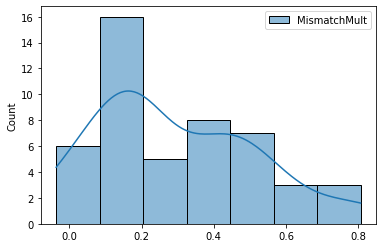

In [5]:
total_data.loc["WY",:].query("emissions=='95% by 2035'")
sns.histplot(data=total_data.loc["WV",:].query("emissions=='95% by 2035'"),
             kde=True,color="gray")

https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py

In [99]:
cmap1 = sns.color_palette("Greys_r", as_cmap=True)
cmap = sns.color_palette("Blues", as_cmap=True)
norm1 = matplotlib.colors.Normalize(vmin=-0.3, vmax=0)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)

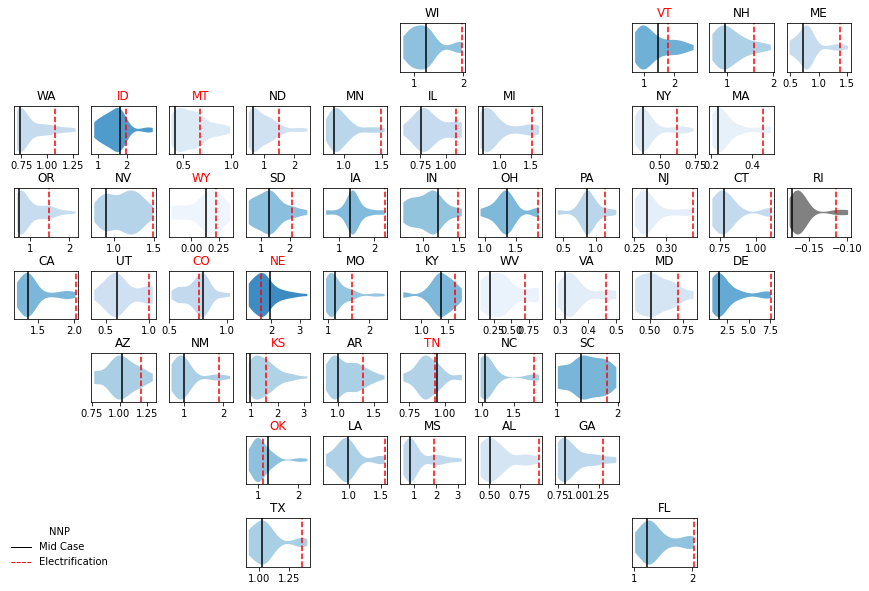

In [105]:
plt.rc('figure', figsize=(15,10))
f, axes = plt.subplots(7,11)
f.subplots_adjust(hspace=0.7)
ems_target = "NNP" #"95% by 2050" # "NNP"
add_name = "" # "_95_by_2050"

for this_state in state_coords["state"].to_list():
    sample_data = total_data.query("emissions==@ems_target").loc[this_state]
    row_coord = state_coords.query("state==@this_state")["row"].iloc[0]
    col_coord = state_coords.query("state==@this_state")["col"].iloc[0]
    mid_case_name = 'Mid_Case'+add_name
    mid_case_name = mid_case_name.replace("_"," ")
    mid_case_val = sample_data.query("scenario==@mid_case_name").query("analysis=='v6.2jedi_mid'")["MismatchMult"].iloc[0]
    if mid_case_val > 0:
        rgba = cmap(norm(mid_case_val))
    else:
        rgba = cmap1(norm1(mid_case_val))
    this_ax = axes[row_coord,col_coord]
    #this_ax.set_facecolor(rgba)
    
    plot_data = sample_data.loc[:,"MismatchMult"]
    if statistics.variance(plot_data) > 0.0001:
        parts = this_ax.violinplot(plot_data, vert=False,showmeans=False, showmedians=False,
                                   showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(rgba)
            #pc.set_edgecolor('black')
            pc.set_alpha(1)
        #sns.histplot(data=plot_data,kde=True,color="lightgrey",edgecolor='k',ax=this_ax,alpha=1)
        this_ax.axvline(x=mid_case_val,color="black")
        #this_ax.set_ylim([0,30])
        ele_name = 'Electrification_EnhancedFlex'+add_name
        ele_name = ele_name.replace("_"," ")
        ele_data = sample_data.query("scenario==@ele_name").query("analysis=='v6.2jedi_high'")["MismatchMult"].iloc[0]
        this_ax.axvline(x=ele_data,color="red",linestyle = "--")
    else:
        this_ax.set_xticks([])
        
    #if col_coord != 0:
    this_ax.set_yticks([])
    this_ax.set(xlabel = None,ylabel = None)
    
    stdev_val = plot_data.mean()+plot_data.std()
    if stdev_val < ele_data:
        this_ax.set_title(this_state,color="black")
    else:
        this_ax.set_title(this_state,color="red")

for i in [0,1,2,3,4,6,7,18,21,43,44,52,53,54,55,56,57,63,64,65,66,67,68,70,71,72,73,75,76]:
    f.delaxes(axes.flatten()[i])
    
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="red", lw=1,linestyle="--")]
plt.legend(custom_lines, ["Mid Case","Electrification"],title = ems_target,frameon=False,
                      bbox_to_anchor=(-8, 1))
plt.show()
f.savefig("ABS_state_employment"+add_name+".png",bbox_inches='tight',dpi=600)